In [128]:
# Cell 1: Setup & Configuration (UPDATED)
import numpy as np
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass, label
import pandas as pd
from scipy.stats import pearsonr
from sklearn.manifold import MDS
from scipy.spatial import procrustes
import seaborn as sns
from scipy.stats import linregress

# Use the CSV-driven configuration from the functional extraction notebook
BASE_DIR = Path("/user_data/csimmon2/long_pt")
OUTPUT_DIR = BASE_DIR / "analyses" / "rsa_corrected"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load subject info from CSV (same as functional extraction notebook)
CSV_FILE = Path('/user_data/csimmon2/git_repos/long_pt/long_pt_sub_info.csv')
df = pd.read_csv(CSV_FILE)
SESSION_START = {'sub-010': 2, 'sub-018': 2, 'sub-068': 2}

# Use the same subject loading function
def load_subjects_by_group(group_filter=None, patient_only=True):
    """Load subjects dynamically from CSV"""
    filtered_df = df.copy()
    
    if patient_only is True:
        filtered_df = filtered_df[filtered_df['patient'] == 1]
    elif patient_only is False:
        filtered_df = filtered_df[filtered_df['patient'] == 0]
    
    if group_filter:
        if isinstance(group_filter, str):
            group_filter = [group_filter]
        filtered_df = filtered_df[filtered_df['group'].isin(group_filter)]
    
    subjects = {}
    
    for _, row in filtered_df.iterrows():
        subject_id = row['sub']
        
        subj_dir = BASE_DIR / subject_id
        if not subj_dir.exists():
            continue
            
        sessions = []
        for ses_dir in subj_dir.glob('ses-*'):
            if ses_dir.is_dir():
                sessions.append(ses_dir.name.replace('ses-', ''))
        
        if not sessions:
            continue
            
        sessions = sorted(sessions, key=lambda x: int(x))
        start_session = SESSION_START.get(subject_id, 1)
        available_sessions = [s for s in sessions if int(s) >= start_session]
        
        if not available_sessions:
            continue
            
        hemisphere_full = row.get('intact_hemi', 'left') if pd.notna(row.get('intact_hemi', None)) else 'left'
        hemisphere = 'l' if hemisphere_full == 'left' else 'r'
        
        subjects[subject_id] = {
            'code': f"{row['group']}{subject_id.split('-')[1]}",
            'sessions': available_sessions,
            'hemi': hemisphere,
            'group': row['group'],
            'patient_status': 'patient' if row['patient'] == 1 else 'control',
            'age_1': row['age_1'] if pd.notna(row['age_1']) else None
        }
    
    return subjects

# Reload with correct hemisphere mapping
ALL_PATIENTS = load_subjects_by_group(group_filter=None, patient_only=True)
OTC_PATIENTS = load_subjects_by_group(group_filter='OTC', patient_only=True)
NON_OTC_PATIENTS = load_subjects_by_group(group_filter='nonOTC', patient_only=True)
ALL_CONTROLS = load_subjects_by_group(group_filter=None, patient_only=False)
ALL_SUBJECTS = {**ALL_PATIENTS, **ALL_CONTROLS} # Combine patients and controls

# Update analysis subjects
ANALYSIS_SUBJECTS = ALL_SUBJECTS

# NOTE ROI COPE MAP HERE MATCHES FUNCTIONAL EXTRACTION
#COPE_MAP = {
#    'face': 10,  # Updated to match functional extraction
#    'word': 12,
#    'object': 3,
#    'house': 11  # Updated to match functional extraction
#}


# COPE MAP HERE IS THE ONE WE WANT TO USE FOR RSA
COPE_MAP = {
    'face': 1,
    'word': 12,
    'object': 3,
    'house': 2
}

print(f"RSA Analysis - {len(ANALYSIS_SUBJECTS)} subjects loaded")
print("Subjects:", list(ANALYSIS_SUBJECTS.keys()))

RSA Analysis - 25 subjects loaded
Subjects: ['sub-004', 'sub-007', 'sub-008', 'sub-010', 'sub-017', 'sub-021', 'sub-045', 'sub-047', 'sub-049', 'sub-070', 'sub-072', 'sub-073', 'sub-079', 'sub-081', 'sub-086', 'sub-108', 'sub-018', 'sub-022', 'sub-025', 'sub-027', 'sub-052', 'sub-058', 'sub-062', 'sub-064', 'sub-068']


In [129]:
# Cell 2: Extract Functional ROIs (INTEGRATED)
from scipy.ndimage import label, center_of_mass

def extract_functional_rois_final(subject_id, subjects_dict, threshold_z=2.3):
    """Extract functional cluster ROIs across all sessions"""
    
    if subject_id not in subjects_dict:
        print(f"❌ {subject_id} not in analysis group")
        return {}
        
    info = subjects_dict[subject_id]
    code = info['code']
    hemi = info['hemi']
    sessions = info['sessions']
    first_session = sessions[0]
    
    print(f"\n{code} - Extracting Functional ROIs [{info['group']} {info['patient_status']}]")
    
    all_results = {}
    
    # Process each category using COPE_MAP
    for category, cope_num in COPE_MAP.items():
        all_results[category] = {}
        
        # Load category-specific mask
        mask_file = BASE_DIR / subject_id / f'ses-{first_session}' / 'ROIs' / f'{hemi}_{category}_searchmask.nii.gz'
        if not mask_file.exists():
            print(f"  ⚠️  {category}: mask not found")
            continue
        
        mask = nib.load(mask_file).get_fdata() > 0
        affine = nib.load(mask_file).affine
        
        # Process each session
        for session in sessions:
            feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
            
            # Select correct zstat file
            zstat_file = 'zstat1.nii.gz' if session == first_session else f'zstat1_ses{first_session}.nii.gz'
            cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / zstat_file
            
            if not cope_file.exists():
                continue
            
            # Load functional activation
            zstat = nib.load(cope_file).get_fdata()
            suprathresh = (zstat > threshold_z) & mask
            
            if suprathresh.sum() < 50:
                continue
            
            # Find largest cluster
            labeled, n_clusters = label(suprathresh)
            if n_clusters == 0:
                continue
                
            cluster_sizes = [(labeled == i).sum() for i in range(1, n_clusters + 1)]
            largest_idx = np.argmax(cluster_sizes) + 1
            roi_mask = (labeled == largest_idx)
            
            # Extract metrics
            peak_idx = np.unravel_index(np.argmax(zstat * roi_mask), zstat.shape)
            peak_z = zstat[peak_idx]
            centroid = nib.affines.apply_affine(affine, center_of_mass(roi_mask))
            
            # Store results
            all_results[category][session] = {
                'n_voxels': cluster_sizes[largest_idx - 1],
                'peak_z': peak_z,
                'centroid': centroid,
                'roi_mask': roi_mask
            }
    
    return all_results

# Extract functional ROIs for all analysis subjects
print("="*70)
print("EXTRACTING FUNCTIONAL ROIs FOR RSA ANALYSIS")
print("="*70)

golarai_functional_final = {}

for subject_id in ANALYSIS_SUBJECTS.keys():
    try:
        golarai_functional_final[subject_id] = extract_functional_rois_final(subject_id, ANALYSIS_SUBJECTS, threshold_z=2.3)
    except Exception as e:
        print(f"❌ {subject_id} failed: {e}")
        golarai_functional_final[subject_id] = {}

print(f"\n✓ Functional ROI extraction complete for {len(golarai_functional_final)} subjects!")

# Quick summary
for subject_id, results in golarai_functional_final.items():
    if subject_id in ANALYSIS_SUBJECTS:
        code = ANALYSIS_SUBJECTS[subject_id]['code']
        categories = list(results.keys())
        total_sessions = sum(len(sessions) for sessions in results.values())
        print(f"  {code}: {len(categories)} categories, {total_sessions} total ROIs")

EXTRACTING FUNCTIONAL ROIs FOR RSA ANALYSIS

OTC004 - Extracting Functional ROIs [OTC patient]

nonOTC007 - Extracting Functional ROIs [nonOTC patient]

OTC008 - Extracting Functional ROIs [OTC patient]

OTC010 - Extracting Functional ROIs [OTC patient]

OTC017 - Extracting Functional ROIs [OTC patient]

OTC021 - Extracting Functional ROIs [OTC patient]

nonOTC045 - Extracting Functional ROIs [nonOTC patient]

nonOTC047 - Extracting Functional ROIs [nonOTC patient]

nonOTC049 - Extracting Functional ROIs [nonOTC patient]

nonOTC070 - Extracting Functional ROIs [nonOTC patient]

nonOTC072 - Extracting Functional ROIs [nonOTC patient]

nonOTC073 - Extracting Functional ROIs [nonOTC patient]

OTC079 - Extracting Functional ROIs [OTC patient]

nonOTC081 - Extracting Functional ROIs [nonOTC patient]

nonOTC086 - Extracting Functional ROIs [nonOTC patient]

OTC108 - Extracting Functional ROIs [OTC patient]
  ⚠️  face: mask not found
  ⚠️  word: mask not found
  ⚠️  object: mask not found
  ⚠

In [130]:
# Cell 3: RSA Helper Functions (UPDATED)
def create_6mm_sphere(peak_coord, affine, brain_shape, radius=6):
    """Create a 6mm sphere around a peak."""
    grid_coords = np.array(np.meshgrid(
        np.arange(brain_shape[0]), 
        np.arange(brain_shape[1]), 
        np.arange(brain_shape[2]),
        indexing='ij'
    )).reshape(3, -1).T
    
    grid_world = nib.affines.apply_affine(affine, grid_coords)
    distances = np.linalg.norm(grid_world - peak_coord, axis=1)
    
    mask_3d = np.zeros(brain_shape, dtype=bool)
    within = grid_coords[distances <= radius]
    for coord in within:
        mask_3d[coord[0], coord[1], coord[2]] = True
    
    return mask_3d

def extract_beta_patterns_from_sphere(subject_id, session, sphere_mask, category_copes):
    """Extract beta values from a 6mm sphere for all categories."""
    info = ANALYSIS_SUBJECTS[subject_id]  # UPDATED: Use ANALYSIS_SUBJECTS
    first_session = info['sessions'][0]
    
    feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
    
    beta_patterns = []
    valid_categories = []
    
    for category, cope_num in category_copes.items():
        # UPDATED: Use correct file naming based on session
        if session == first_session:
            cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / 'cope1.nii.gz'
        else:
            cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / f'cope1_ses{first_session}.nii.gz'
        
        if not cope_file.exists():
            continue
        
        cope_data = nib.load(cope_file).get_fdata()
        roi_betas = cope_data[sphere_mask]
        roi_betas = roi_betas[np.isfinite(roi_betas)]
        
        if len(roi_betas) > 0:
            beta_patterns.append(roi_betas)
            valid_categories.append(category)
    
    if len(beta_patterns) == 0:
        return None, None
    
    min_voxels = min(len(b) for b in beta_patterns)
    beta_patterns = [b[:min_voxels] for b in beta_patterns]
    beta_matrix = np.column_stack(beta_patterns)
    
    return beta_matrix, valid_categories

def compute_rdm(beta_matrix, fisher_transform=True):
    """Compute Representational Dissimilarity Matrix."""
    correlation_matrix = np.corrcoef(beta_matrix.T)
    rdm = 1 - correlation_matrix
    
    if fisher_transform:
        correlation_matrix_fisher = np.arctanh(np.clip(correlation_matrix, -0.999, 0.999))
        return rdm, correlation_matrix_fisher
    else:
        return rdm, correlation_matrix

print("✓ RSA helper functions updated")

✓ RSA helper functions updated


In [131]:
# Cell 4: Session-Specific RSA Analysis (UPDATED)
def extract_all_rdms_6mm_session_specific(functional_results, analysis_subjects):
    """Extract RDMs from 6mm spheres using SESSION-SPECIFIC ROIs - UPDATED"""
    all_rdms = {}
    
    for subject_id in analysis_subjects.keys():  # UPDATED: Use analysis_subjects
        if subject_id not in functional_results:
            continue
            
        info = analysis_subjects[subject_id]  # UPDATED: Use analysis_subjects
        code = info['code']
        hemi = info['hemi']
        sessions = info['sessions']
        first_session = sessions[0]
        
        # UPDATED: Use first session for reference
        ref_file = BASE_DIR / subject_id / f'ses-{first_session}' / 'ROIs' / f'{hemi}_face_searchmask.nii.gz'
        if not ref_file.exists():
            print(f"⚠️ Reference file missing for {code}: {ref_file}")
            continue
            
        ref_img = nib.load(ref_file)
        affine = ref_img.affine
        brain_shape = ref_img.shape
        
        print(f"\n{code} ({info['group']} {info['patient_status']}): SESSION-SPECIFIC RSA Analysis")
        
        all_rdms[subject_id] = {}
        
        for roi_name in ['face', 'word', 'object', 'house']:
            if roi_name not in functional_results[subject_id]:
                continue
            
            all_rdms[subject_id][roi_name] = {
                'rdms': {},
                'correlation_matrices': {},
                'beta_patterns': {},
                'valid_categories': None,
                'session_peaks': {},
                'session_n_voxels': {}
            }
            
            for session in sessions:
                if session not in functional_results[subject_id][roi_name]:
                    continue
                
                # SESSION-SPECIFIC peak and sphere
                peak = functional_results[subject_id][roi_name][session]['centroid']
                sphere_mask = create_6mm_sphere(peak, affine, brain_shape, radius=6)
                n_voxels = sphere_mask.sum()
                
                all_rdms[subject_id][roi_name]['session_peaks'][session] = peak
                all_rdms[subject_id][roi_name]['session_n_voxels'][session] = n_voxels
                
                beta_matrix, valid_cats = extract_beta_patterns_from_sphere(
                    subject_id, session, sphere_mask, COPE_MAP  # UPDATED: Use COPE_MAP
                )
                
                if beta_matrix is None:
                    continue
                
                rdm, corr_matrix_fisher = compute_rdm(beta_matrix, fisher_transform=True)
                
                all_rdms[subject_id][roi_name]['rdms'][session] = rdm
                all_rdms[subject_id][roi_name]['correlation_matrices'][session] = corr_matrix_fisher
                all_rdms[subject_id][roi_name]['beta_patterns'][session] = beta_matrix
                all_rdms[subject_id][roi_name]['valid_categories'] = valid_cats
                
                print(f"  {roi_name} ses-{session}: {n_voxels} voxels")
    
    return all_rdms

# Run with session-specific ROIs
print("STEP 1: SESSION-SPECIFIC ROI RSA")
print("="*70)
rsa_rdms_6mm_session_specific = extract_all_rdms_6mm_session_specific(golarai_functional_final, ANALYSIS_SUBJECTS)
print("✓ Session-specific analysis complete!")

STEP 1: SESSION-SPECIFIC ROI RSA

OTC004 (OTC patient): SESSION-SPECIFIC RSA Analysis
  face ses-02: 906 voxels
  face ses-03: 903 voxels
  face ses-05: 899 voxels
  face ses-06: 903 voxels
  word ses-01: 911 voxels
  word ses-02: 899 voxels
  word ses-03: 903 voxels
  word ses-05: 908 voxels
  word ses-06: 899 voxels
  object ses-01: 910 voxels
  object ses-02: 901 voxels
  object ses-03: 914 voxels
  object ses-05: 898 voxels
  object ses-06: 899 voxels
  house ses-01: 905 voxels
  house ses-02: 907 voxels
  house ses-03: 901 voxels
  house ses-05: 903 voxels
  house ses-06: 908 voxels

nonOTC007 (nonOTC patient): SESSION-SPECIFIC RSA Analysis
  face ses-01: 909 voxels
  face ses-03: 909 voxels
  face ses-04: 905 voxels
  word ses-01: 904 voxels
  word ses-03: 906 voxels
  word ses-04: 907 voxels
  object ses-01: 915 voxels
  object ses-03: 894 voxels
  object ses-04: 896 voxels
  house ses-01: 900 voxels
  house ses-03: 916 voxels
  house ses-04: 920 voxels

OTC008 (OTC patient): SE

In [132]:
# Cell 5: Liu's RSA Methodology (UPDATED)
def compute_liu_distinctiveness(all_rdms, analysis_subjects):
    """Compute Liu's preferred vs non-preferred category correlations - UPDATED"""
    roi_preferred = {'face': 'face', 'word': 'word', 'object': 'object', 'house': 'house'}
    
    distinctiveness_results = {}
    
    for subject_id, categories in all_rdms.items():
        if subject_id not in analysis_subjects:
            continue
            
        info = analysis_subjects[subject_id]
        code = info['code']
        group_status = f"{info['group']} {info['patient_status']}"
        
        distinctiveness_results[subject_id] = {}
        
        print(f"\n{code} ({group_status}): Liu's Distinctiveness Analysis")
        
        for roi_name, roi_data in categories.items():
            if not roi_data['correlation_matrices']:
                continue
            
            valid_cats = roi_data['valid_categories']
            if valid_cats is None or len(valid_cats) < 4:
                continue
            
            preferred_cat = roi_preferred[roi_name]
            if preferred_cat not in valid_cats:
                continue
            
            pref_idx = valid_cats.index(preferred_cat)
            nonpref_indices = [i for i, cat in enumerate(valid_cats) if cat != preferred_cat]
            
            distinctiveness_results[subject_id][roi_name] = {}
            
            for session, corr_matrix in roi_data['correlation_matrices'].items():
                pref_vs_nonpref = corr_matrix[pref_idx, nonpref_indices]
                mean_corr = np.mean(pref_vs_nonpref)
                
                distinctiveness_results[subject_id][roi_name][session] = {
                    'liu_distinctiveness': mean_corr,
                    'individual_correlations': pref_vs_nonpref
                }
                
                print(f"  {roi_name} ses-{session}: {mean_corr:.3f}")
    
    return distinctiveness_results

def compute_liu_bootstrapped_slopes(all_rdms, analysis_subjects, n_bootstraps=1000):
    """Liu's bootstrapped linear regression for dissimilarity changes - UPDATED"""
    from scipy.stats import linregress
    
    slope_results = {}
    pairs = [('face', 'word'), ('house', 'object'), ('face', 'object'), ('word', 'house')]
    
    for subject_id, categories in all_rdms.items():
        if subject_id not in analysis_subjects:
            continue
            
        info = analysis_subjects[subject_id]
        code = info['code']
        sessions = info['sessions']
        
        slope_results[subject_id] = {}
        
        print(f"\n{code}: Liu's Bootstrapped Slope Analysis")
        
        for roi_name, roi_data in categories.items():
            if not roi_data['rdms']:
                continue
            
            valid_cats = roi_data['valid_categories']
            if valid_cats is None or len(valid_cats) < 4:
                continue
            
            slope_results[subject_id][roi_name] = {}
            
            for cat1, cat2 in pairs:
                if cat1 not in valid_cats or cat2 not in valid_cats:
                    continue
                
                idx1, idx2 = valid_cats.index(cat1), valid_cats.index(cat2)
                
                session_nums, dissims = [], []
                for session in sessions:
                    if session in roi_data['rdms']:
                        rdm = roi_data['rdms'][session]
                        dissim = rdm[idx1, idx2]
                        session_nums.append(int(session))
                        dissims.append(dissim)
                
                if len(session_nums) < 2:
                    continue
                
                slope = linregress(session_nums, dissims)[0]
                
                null_slopes = []
                for _ in range(n_bootstraps):
                    shuffled = np.random.permutation(dissims)
                    null_slope = linregress(session_nums, shuffled)[0]
                    null_slopes.append(null_slope)
                
                ci_lower = np.percentile(null_slopes, 2.5)
                ci_upper = np.percentile(null_slopes, 97.5)
                significant = slope < ci_lower or slope > ci_upper
                
                slope_results[subject_id][roi_name][f'{cat1}-{cat2}'] = {
                    'observed_slope': slope,
                    'null_slopes': null_slopes,
                    'ci_95': (ci_lower, ci_upper),
                    'significant': significant
                }
                
                sig = "***" if significant else "n.s."
                print(f"  {roi_name} {cat1}-{cat2}: {slope:.4f} {sig}")
    
    return slope_results

# Run Liu's analyses (UPDATED to use ANALYSIS_SUBJECTS)
print("STEP 2: LIU'S RSA METHODOLOGY")
print("="*70)
liu_distinctiveness = compute_liu_distinctiveness(rsa_rdms_6mm_session_specific, ANALYSIS_SUBJECTS)
liu_slopes = compute_liu_bootstrapped_slopes(rsa_rdms_6mm_session_specific, ANALYSIS_SUBJECTS)
print("✓ Liu's methodology complete!")

STEP 2: LIU'S RSA METHODOLOGY

OTC004 (OTC patient): Liu's Distinctiveness Analysis
  face ses-02: 0.346
  face ses-03: -0.025
  face ses-05: 0.103
  face ses-06: 0.128
  word ses-01: -0.165
  word ses-02: 0.352
  word ses-03: 0.300
  word ses-05: 0.707
  word ses-06: 0.334
  object ses-01: -0.402
  object ses-02: -1.061
  object ses-03: -0.912
  object ses-05: -0.936
  object ses-06: -0.661
  house ses-01: -0.946
  house ses-02: -0.911
  house ses-03: -0.335
  house ses-05: -0.940
  house ses-06: -0.472

nonOTC007 (nonOTC patient): Liu's Distinctiveness Analysis
  face ses-01: 0.275
  face ses-03: 0.113
  face ses-04: 0.235
  word ses-01: 0.171
  word ses-03: 0.039
  word ses-04: -0.004
  object ses-01: -0.231
  object ses-03: 0.349
  object ses-04: 0.130
  house ses-01: -0.136
  house ses-03: 0.116
  house ses-04: -0.315

OTC008 (OTC patient): Liu's Distinctiveness Analysis
  face ses-01: 0.372
  face ses-02: 0.469
  word ses-01: 0.222
  word ses-02: 0.213
  object ses-01: -0.080
  o

In [133]:
# CELL: CALCULATE MEASUREMENT ERROR RADII (UPDATED)
def get_bootstrapped_error_radius(pair_peaks, n_bootstraps=1000):
    """Calculate bootstrapped measurement error radius."""
    if not pair_peaks or len(pair_peaks) < 2:
        return 1.0
    
    data = np.array([p['coord'][:2] for p in pair_peaks])
    
    def stat_func(coords):
        if len(np.unique(coords[:, 0])) < 2 or len(np.unique(coords[:, 1])) < 2:
            return 0.0
        return np.sqrt(np.std(coords[:, 0])**2 + np.std(coords[:, 1])**2)
    
    bootstrapped_stats = [stat_func(data[np.random.choice(len(data), len(data), replace=True)]) 
                          for _ in range(n_bootstraps)]
    
    final_radius = np.mean(bootstrapped_stats)
    return final_radius if not np.isnan(final_radius) and final_radius > 0 else stat_func(data)

def calculate_error_radii_for_subjects(functional_results, analysis_subjects):
    """Calculate measurement error radii for all subjects"""
    radii = {}
    
    for subject_id in analysis_subjects.keys():
        if subject_id not in functional_results:
            continue
            
        info = analysis_subjects[subject_id]
        code = info['code']
        radii[subject_id] = {}
        
        print(f"\n{code} - Calculating error radii:")
        
        for category, sessions_data in functional_results[subject_id].items():
            if len(sessions_data) < 2:
                radii[subject_id][category] = 1.0  # Default radius
                print(f"  {category}: 1.0mm (default - insufficient sessions)")
                continue
            
            # Collect peak coordinates for bootstrapping
            pair_peaks = []
            for session, data in sessions_data.items():
                pair_peaks.append({
                    'coord': data['centroid'],
                    'session': session
                })
            
            radius = get_bootstrapped_error_radius(pair_peaks)
            radii[subject_id][category] = radius
            print(f"  {category}: {radius:.2f}mm")
    
    return radii

# Calculate radii for all analysis subjects
print("CALCULATING MEASUREMENT ERROR RADII")
print("="*70)
radii = calculate_error_radii_for_subjects(golarai_functional_final, ANALYSIS_SUBJECTS)
print("✓ Error radii calculated!")

CALCULATING MEASUREMENT ERROR RADII

OTC004 - Calculating error radii:
  face: 7.66mm
  word: 14.38mm
  object: 2.23mm
  house: 5.63mm

nonOTC007 - Calculating error radii:
  face: 3.21mm
  word: 2.78mm
  object: 2.27mm
  house: 4.05mm

OTC008 - Calculating error radii:
  face: 1.01mm
  word: 18.52mm
  object: 2.32mm
  house: 3.02mm

OTC010 - Calculating error radii:
  face: 0.40mm
  word: 11.91mm
  object: 0.94mm
  house: 2.68mm

OTC017 - Calculating error radii:
  face: 3.84mm
  word: 19.02mm
  object: 4.53mm
  house: 16.12mm

OTC021 - Calculating error radii:
  face: 0.55mm
  word: 0.75mm
  object: 1.06mm
  house: 5.57mm

nonOTC045 - Calculating error radii:
  face: 1.95mm
  word: 7.76mm
  object: 0.60mm
  house: 1.41mm

nonOTC047 - Calculating error radii:
  face: 0.36mm
  word: 0.72mm
  object: 0.70mm
  house: 0.20mm

nonOTC049 - Calculating error radii:
  face: 0.23mm
  word: 1.42mm
  object: 0.56mm
  house: 0.48mm

nonOTC070 - Calculating error radii:
  face: 0.37mm
  word: 1.05

In [34]:
# CELL: DRIFT ANALYSIS (UPDATED)
def calculate_centroid_drift(functional_results, radii, analysis_subjects):
    """Calculate drift between sessions for each category - UPDATED"""
    drift_results = {}
    
    for subject_id, categories in functional_results.items():
        if subject_id not in analysis_subjects:
            continue
            
        info = analysis_subjects[subject_id]
        code = info['code']
        group_status = f"{info['group']} {info['patient_status']}"
        
        drift_results[subject_id] = {}
        
        print(f"\n{code} ({group_status}): Centroid Drift Analysis")
        
        for category, sessions_data in categories.items():
            if len(sessions_data) < 2:
                continue
            
            sessions = sorted(sessions_data.keys())
            baseline_session = sessions[0]
            baseline_centroid = sessions_data[baseline_session]['centroid']
            error_radius = radii[subject_id].get(category, 1.0)
            
            drift_results[subject_id][category] = {
                'baseline_session': baseline_session,
                'baseline_centroid': baseline_centroid,
                'error_radius': error_radius,
                'from_baseline_drift': []
            }
            
            # Calculate drift from baseline
            for session in sessions[1:]:
                current_centroid = sessions_data[session]['centroid']
                drift_from_baseline = np.linalg.norm(current_centroid - baseline_centroid)
                
                drift_results[subject_id][category]['from_baseline_drift'].append({
                    'session': session,
                    'distance_mm': drift_from_baseline,
                    'relative_to_error': drift_from_baseline / error_radius
                })
                
                print(f"  {category} ses-{session}: {drift_from_baseline:.2f}mm drift (error radius: {error_radius:.2f}mm)")
    
    return drift_results

# Run drift analysis
print("CALCULATING CENTROID DRIFT")
print("="*70)
drift_data = calculate_centroid_drift(golarai_functional_final, radii, ANALYSIS_SUBJECTS)
print("✓ Drift analysis complete!")

CALCULATING CENTROID DRIFT

OTC004 (OTC patient): Centroid Drift Analysis
  face ses-03: 23.26mm drift (error radius: 7.66mm)
  face ses-05: 24.40mm drift (error radius: 7.66mm)
  face ses-06: 15.05mm drift (error radius: 7.66mm)
  word ses-03: 18.50mm drift (error radius: 9.47mm)
  word ses-05: 1.81mm drift (error radius: 9.47mm)
  word ses-06: 24.41mm drift (error radius: 9.47mm)
  object ses-02: 2.74mm drift (error radius: 1.35mm)
  object ses-03: 4.15mm drift (error radius: 1.35mm)
  object ses-05: 4.18mm drift (error radius: 1.35mm)
  object ses-06: 3.15mm drift (error radius: 1.35mm)
  house ses-02: 2.68mm drift (error radius: 5.17mm)
  house ses-03: 3.18mm drift (error radius: 5.17mm)
  house ses-05: 2.14mm drift (error radius: 5.17mm)
  house ses-06: 15.66mm drift (error radius: 5.17mm)

nonOTC007 (nonOTC patient): Centroid Drift Analysis
  face ses-03: 8.49mm drift (error radius: 3.13mm)
  face ses-04: 3.46mm drift (error radius: 3.13mm)
  word ses-04: 18.53mm drift (error rad

In [35]:
# CELL: BILATERAL VS UNILATERAL CATEGORY ANALYSIS (UPDATED)
def analyze_bilateral_vs_unilateral(drift_data, distinctiveness_results, slope_results, analysis_subjects):
    """
    Comprehensive analysis comparing bilateral vs unilateral categories - UPDATED
    """
    
    # Category groupings
    bilateral_categories = ['object', 'house']
    unilateral_categories = ['face', 'word']
    
    results = {
        'spatial_drift': {},
        'representational_stability': {},
        'reorganization_patterns': {}
    }
    
    print("BILATERAL vs UNILATERAL CATEGORY ANALYSIS")
    print("="*70)
    
    # ============================================================================
    # PART 1: SPATIAL DRIFT COMPARISON
    # ============================================================================
    
    print("\n1. SPATIAL DRIFT ANALYSIS")
    print("-" * 40)
    
    all_bilateral_drift = []
    all_unilateral_drift = []
    
    for subject_id, categories in drift_data.items():
        if subject_id not in analysis_subjects:
            continue
            
        info = analysis_subjects[subject_id]
        code = info['code']
        group_status = f"{info['group']} {info['patient_status']}"
        
        print(f"\n{code} ({group_status}):")
        
        subject_bilateral = []
        subject_unilateral = []
        
        for category, data in categories.items():
            if not data['from_baseline_drift']:
                continue
            
            # Get maximum drift from baseline
            max_drift = max([d['distance_mm'] for d in data['from_baseline_drift']])
            mean_drift = np.mean([d['distance_mm'] for d in data['from_baseline_drift']])
            
            if category in bilateral_categories:
                subject_bilateral.append(mean_drift)
                all_bilateral_drift.append(mean_drift)
                print(f"  {category} (bilateral): {mean_drift:.2f}mm avg drift")
            elif category in unilateral_categories:
                subject_unilateral.append(mean_drift)
                all_unilateral_drift.append(mean_drift)
                print(f"  {category} (unilateral): {mean_drift:.2f}mm avg drift")
        
        # Subject-level comparison
        if subject_bilateral and subject_unilateral:
            bilateral_avg = np.mean(subject_bilateral)
            unilateral_avg = np.mean(subject_unilateral)
            print(f"  → Bilateral avg: {bilateral_avg:.2f}mm")
            print(f"  → Unilateral avg: {unilateral_avg:.2f}mm")
            print(f"  → Difference: {unilateral_avg - bilateral_avg:.2f}mm")
    
    # Overall statistics
    if all_bilateral_drift and all_unilateral_drift:
        from scipy.stats import ttest_ind
        
        print(f"\nOVERALL SPATIAL DRIFT COMPARISON:")
        print(f"Bilateral categories: {np.mean(all_bilateral_drift):.2f} ± {np.std(all_bilateral_drift):.2f}mm")
        print(f"Unilateral categories: {np.mean(all_unilateral_drift):.2f} ± {np.std(all_unilateral_drift):.2f}mm")
        
        stat, p_val = ttest_ind(all_bilateral_drift, all_unilateral_drift)
        print(f"t-test: t={stat:.3f}, p={p_val:.3f}")
        
        results['spatial_drift'] = {
            'bilateral_drifts': all_bilateral_drift,
            'unilateral_drifts': all_unilateral_drift,
            'bilateral_mean': np.mean(all_bilateral_drift),
            'unilateral_mean': np.mean(all_unilateral_drift),
            'test_statistic': stat,
            'p_value': p_val
        }
    
    return results

# Note: You'll need to add distinctiveness_results and slope_results analysis first
# For now, run with just drift data:
print("Running bilateral vs unilateral analysis with available data...")

# Simplified version focusing on spatial drift only
bilateral_vs_unilateral_results = analyze_bilateral_vs_unilateral(
    drift_data, {}, {}, ANALYSIS_SUBJECTS  # Empty dicts for missing analyses
)

Running bilateral vs unilateral analysis with available data...
BILATERAL vs UNILATERAL CATEGORY ANALYSIS

1. SPATIAL DRIFT ANALYSIS
----------------------------------------

OTC004 (OTC patient):
  face (unilateral): 20.90mm avg drift
  word (unilateral): 14.91mm avg drift
  object (bilateral): 3.56mm avg drift
  house (bilateral): 5.91mm avg drift
  → Bilateral avg: 4.74mm
  → Unilateral avg: 17.90mm
  → Difference: 13.17mm

nonOTC007 (nonOTC patient):
  face (unilateral): 5.97mm avg drift
  word (unilateral): 18.53mm avg drift
  object (bilateral): 4.67mm avg drift
  house (bilateral): 22.84mm avg drift
  → Bilateral avg: 13.76mm
  → Unilateral avg: 12.25mm
  → Difference: -1.51mm

OTC008 (OTC patient):
  face (unilateral): 4.13mm avg drift
  object (bilateral): 11.37mm avg drift
  house (bilateral): 17.59mm avg drift
  → Bilateral avg: 14.48mm
  → Unilateral avg: 4.13mm
  → Difference: -10.35mm

OTC010 (OTC patient):
  face (unilateral): 3.54mm avg drift
  word (unilateral): 22.07m

In [51]:
# CELL: Complete Analysis with Subject Exclusion
def analyze_spatial_representational_coupling_complete_with_exclusion(drift_data, distinctiveness_data, analysis_subjects):
    """
    Complete spatial-representational coupling analysis with simple subject exclusion
    """
    
    # SIMPLE EXCLUSION LIST - just add subjects here as needed
    subjects_to_skip = ['OTC079', 'OTC108', 'control068']  # Add others if they have all zeros
    
    print("FINAL ANALYSIS: SPATIAL-REPRESENTATIONAL COUPLING (COMPLETE)")
    print("="*80)
    print(f"Excluding subjects: {subjects_to_skip}")
    
    bilateral_categories = ['object', 'house']
    unilateral_categories = ['face', 'word']
    
    results = {}
    
    for subject_id in analysis_subjects.keys():
        # SKIP EXCLUDED SUBJECTS
        if analysis_subjects[subject_id]['code'] in subjects_to_skip:
            continue
            
        if subject_id not in drift_data:
            continue
            
        info = analysis_subjects[subject_id]
        code = info['code']
        group_status = f"{info['group']} {info['patient_status']}"
        
        print(f"\n{code} ({group_status})")
        print("-" * 50)
        
        results[subject_id] = {
            'spatial_changes': {},
            'representational_changes': {},
            'coupling_data': []
        }
        
        # Calculate change scores for each ROI
        for category in ['face', 'word', 'object', 'house']:
            
            # SPATIAL CHANGE: Mean drift from baseline
            if (category in drift_data.get(subject_id, {}) and 
                drift_data[subject_id][category]['from_baseline_drift']):
                
                spatial_drifts = [d['distance_mm'] for d in drift_data[subject_id][category]['from_baseline_drift']]
                mean_spatial_change = np.mean(spatial_drifts)
            else:
                mean_spatial_change = 0
            
            # REPRESENTATIONAL CHANGE: Change in distinctiveness
            if (subject_id in distinctiveness_data and 
                category in distinctiveness_data[subject_id]):
                
                sessions = sorted(distinctiveness_data[subject_id][category].keys())
                if len(sessions) >= 2:
                    baseline_dist = distinctiveness_data[subject_id][category][sessions[0]]['liu_distinctiveness']
                    final_dist = distinctiveness_data[subject_id][category][sessions[-1]]['liu_distinctiveness']
                    representational_change = abs(final_dist - baseline_dist)
                else:
                    representational_change = 0
            else:
                representational_change = 0
            
            # Store results
            results[subject_id]['spatial_changes'][category] = mean_spatial_change
            results[subject_id]['representational_changes'][category] = representational_change
            
            print(f"  {category.upper()}: spatial={mean_spatial_change:.2f}mm, repr={representational_change:.3f}")
    
    return results

# Run the complete analysis with exclusion
final_results_complete = analyze_spatial_representational_coupling_complete_with_exclusion(
    drift_data, liu_distinctiveness, ANALYSIS_SUBJECTS
)

# Create the complete table with exclusion  
def create_spatial_representational_table_with_exclusion(final_results, analysis_subjects):
    """Create comprehensive table with subject exclusion"""
    
    subjects_to_skip = ['OTC079', 'OTC108', 'control068']  # Same exclusion list
    
    table_data = []
    
    for subject_id, results_data in final_results.items():
        if subject_id not in analysis_subjects:
            continue
        
        info = analysis_subjects[subject_id]
        code = info['code']
        
        # Skip excluded subjects  
        if code in subjects_to_skip:
            continue
            
        # [Rest of the table creation logic exactly as before]
        group = info['group']
        patient_status = info['patient_status']
        hemisphere = info['hemi']
        
        spatial_data = results_data['spatial_changes']
        repr_data = results_data['representational_changes']
        
        bilateral_cats = ['object', 'house']
        unilateral_cats = ['face', 'word']
        
        bilateral_spatial = []
        bilateral_repr = []
        unilateral_spatial = []
        unilateral_repr = []
        
        for category in bilateral_cats:
            if category in spatial_data and spatial_data[category] > 0:
                bilateral_spatial.append(spatial_data[category])
                bilateral_repr.append(repr_data.get(category, 0))
        
        for category in unilateral_cats:
            if category in spatial_data and spatial_data[category] > 0:
                unilateral_spatial.append(spatial_data[category])
                unilateral_repr.append(repr_data.get(category, 0))
        
        # Add individual category rows
        for category in ['face', 'word', 'object', 'house']:
            if category not in spatial_data:
                continue
                
            category_type = 'Bilateral' if category in bilateral_cats else 'Unilateral'
            
            table_data.append({
                'Subject': code,
                'Group': group,
                'Status': patient_status,
                'Hemisphere': hemisphere,
                'Category': category.title(),
                'Category_Type': category_type,
                'Spatial_Drift_mm': round(spatial_data[category], 2),
                'Representational_Change': round(repr_data.get(category, 0), 3),
                'Sessions': len(analysis_subjects[subject_id]['sessions'])
            })
        
        # Add summary rows
        if bilateral_spatial:
            table_data.append({
                'Subject': code, 'Group': group, 'Status': patient_status, 'Hemisphere': hemisphere,
                'Category': 'BILATERAL_AVG', 'Category_Type': 'Summary',
                'Spatial_Drift_mm': round(np.mean(bilateral_spatial), 2),
                'Representational_Change': round(np.mean(bilateral_repr), 3),
                'Sessions': ''
            })
        
        if unilateral_spatial:
            table_data.append({
                'Subject': code, 'Group': group, 'Status': patient_status, 'Hemisphere': hemisphere,
                'Category': 'UNILATERAL_AVG', 'Category_Type': 'Summary',
                'Spatial_Drift_mm': round(np.mean(unilateral_spatial), 2),
                'Representational_Change': round(np.mean(unilateral_repr), 3),
                'Sessions': ''
            })
    
    df = pd.DataFrame(table_data)
    
    # [All the same detailed analysis as before]
    print("SPATIAL DRIFT vs REPRESENTATIONAL CHANGE: COMPREHENSIVE ANALYSIS")
    print("="*80)
    
    patients = df[df['Status'] == 'patient']
    if len(patients) > 0:
        print("\nPATIENT DATA:")
        print(patients.to_string(index=False))
    
    # [Continue with all the group analysis, statistics, etc. as before]
    print(f"\nGROUP ANALYSIS:")
    print("-" * 50)
    
    for group in df['Group'].unique():
        group_data = df[(df['Group'] == group) & (df['Category_Type'] != 'Summary')]
        
        if len(group_data) > 0:
            print(f"\n{group.upper()} GROUP:")
            bilateral = group_data[group_data['Category_Type'] == 'Bilateral']
            unilateral = group_data[group_data['Category_Type'] == 'Unilateral']
            
            if len(bilateral) > 0 and len(unilateral) > 0:
                bilateral_spatial = bilateral['Spatial_Drift_mm'].mean()
                bilateral_repr = bilateral['Representational_Change'].mean()
                unilateral_spatial = unilateral['Spatial_Drift_mm'].mean()
                unilateral_repr = unilateral['Representational_Change'].mean()
                
                print(f"  Bilateral:  spatial={bilateral_spatial:.1f}mm, repr={bilateral_repr:.3f}")
                print(f"  Unilateral: spatial={unilateral_spatial:.1f}mm, repr={unilateral_repr:.3f}")
                
                if bilateral_repr > unilateral_repr:
                    print(f"  → Bilateral categories show more representational change")
                if unilateral_spatial > bilateral_spatial:
                    print(f"  → Unilateral categories show more spatial drift")
    
    return df

# Create the complete table with exclusion
results_table_complete = create_spatial_representational_table_with_exclusion(final_results_complete, ANALYSIS_SUBJECTS)

print(f"\n✓ Complete analysis with {len(final_results_complete)} subjects!")

FINAL ANALYSIS: SPATIAL-REPRESENTATIONAL COUPLING (COMPLETE)
Excluding subjects: ['OTC079', 'OTC108', 'control068']

OTC004 (OTC patient)
--------------------------------------------------
  FACE: spatial=20.90mm, repr=0.218
  WORD: spatial=14.91mm, repr=0.082
  OBJECT: spatial=3.56mm, repr=0.099
  HOUSE: spatial=5.91mm, repr=0.487

nonOTC007 (nonOTC patient)
--------------------------------------------------
  FACE: spatial=5.97mm, repr=0.039
  WORD: spatial=18.53mm, repr=0.016
  OBJECT: spatial=4.67mm, repr=0.109
  HOUSE: spatial=22.84mm, repr=0.093

OTC008 (OTC patient)
--------------------------------------------------
  FACE: spatial=4.13mm, repr=0.097
  WORD: spatial=0.00mm, repr=0.000
  OBJECT: spatial=11.37mm, repr=0.748
  HOUSE: spatial=17.59mm, repr=0.035

OTC010 (OTC patient)
--------------------------------------------------
  FACE: spatial=3.54mm, repr=0.111
  WORD: spatial=22.07mm, repr=0.290
  OBJECT: spatial=2.66mm, repr=0.134
  HOUSE: spatial=14.10mm, repr=0.430

OTC01

In [60]:
# Actually RUN the hemisphere-specific analysis
def analyze_coupling_by_hemisphere_and_group(results_table):
    """Proper coupling analysis accounting for hemisphere of resection"""
    
    # Split patients by hemisphere of resection
    left_resection = results_table[(results_table['Status'] == 'patient') & (results_table['Hemisphere'] == 'l')]
    right_resection = results_table[(results_table['Status'] == 'patient') & (results_table['Hemisphere'] == 'r')]
    controls = results_table[results_table['Status'] == 'control']
    
    print("SPATIAL-REPRESENTATIONAL COUPLING BY HEMISPHERE")
    print("="*60)
    
    for group_name, group_data in [('Left Resection', left_resection), 
                                   ('Right Resection', right_resection), 
                                   ('Controls', controls)]:
        if len(group_data) < 5:
            continue
            
        # Remove summary rows
        group_data = group_data[group_data['Category_Type'] != 'Summary']
        
        # Separate by category type and lateralization
        face_word = group_data[group_data['Category'].isin(['Face', 'Word'])]
        object_house = group_data[group_data['Category'].isin(['Object', 'House'])]
        
        print(f"\n{group_name}:")
        for cat_type, cat_data in [('Face/Word (unilateral)', face_word), 
                                  ('Object/House (bilateral)', object_house)]:
            if len(cat_data) > 2:
                spatial = cat_data['Spatial_Drift_mm']
                repr_change = cat_data['Representational_Change']
                corr = np.corrcoef(spatial, repr_change)[0,1]
                print(f"  {cat_type}: r={corr:.3f} (n={len(cat_data)}) | spatial={spatial.mean():.1f}mm, repr={repr_change.mean():.3f}")

# CALL the function
analyze_coupling_by_hemisphere_and_group(results_table_complete)

SPATIAL-REPRESENTATIONAL COUPLING BY HEMISPHERE

Left Resection:
  Face/Word (unilateral): r=-0.034 (n=14) | spatial=6.9mm, repr=0.104
  Object/House (bilateral): r=0.227 (n=14) | spatial=5.5mm, repr=0.170

Right Resection:
  Face/Word (unilateral): r=0.360 (n=14) | spatial=10.5mm, repr=0.167
  Object/House (bilateral): r=0.341 (n=14) | spatial=9.2mm, repr=0.272

Controls:
  Face/Word (unilateral): r=-0.205 (n=16) | spatial=7.0mm, repr=0.095
  Object/House (bilateral): r=0.468 (n=16) | spatial=7.3mm, repr=0.212


In [61]:
def hemisphere_specific_analysis(results_table):
    """Analyze effects based on hemisphere of resection"""
    
    print("\nHEMISPHERE-SPECIFIC EFFECTS ON LATERALIZED CATEGORIES")
    print("="*60)
    
    # Remove summary rows
    clean_data = results_table[results_table['Category_Type'] != 'Summary']
    
    # Face processing (typically right-lateralized)
    face_data = clean_data[clean_data['Category'] == 'Face']
    left_res_face = face_data[face_data['Hemisphere'] == 'l']  # Left resection = right hemisphere intact = good for faces
    right_res_face = face_data[face_data['Hemisphere'] == 'r'] # Right resection = left hemisphere intact = poor for faces
    
    print("FACE processing (typically right-lateralized):")
    if len(left_res_face) > 0:
        print(f"  Left resection (right intact - GOOD): {left_res_face['Spatial_Drift_mm'].mean():.1f}mm spatial, {left_res_face['Representational_Change'].mean():.3f} repr")
    if len(right_res_face) > 0:
        print(f"  Right resection (left intact - POOR): {right_res_face['Spatial_Drift_mm'].mean():.1f}mm spatial, {right_res_face['Representational_Change'].mean():.3f} repr")
    
    # Word processing (typically left-lateralized) 
    word_data = clean_data[clean_data['Category'] == 'Word']
    left_res_word = word_data[word_data['Hemisphere'] == 'l']   # Left resection = atypical word processing
    right_res_word = word_data[word_data['Hemisphere'] == 'r']  # Right resection = typical word processing
    
    print("\nWORD processing (typically left-lateralized):")
    if len(left_res_word) > 0:
        print(f"  Left resection (atypical): {left_res_word['Spatial_Drift_mm'].mean():.1f}mm spatial, {left_res_word['Representational_Change'].mean():.3f} repr") 
    if len(right_res_word) > 0:
        print(f"  Right resection (typical): {right_res_word['Spatial_Drift_mm'].mean():.1f}mm spatial, {right_res_word['Representational_Change'].mean():.3f} repr")

# CALL the function
hemisphere_specific_analysis(results_table_complete)


HEMISPHERE-SPECIFIC EFFECTS ON LATERALIZED CATEGORIES
FACE processing (typically right-lateralized):
  Left resection (right intact - GOOD): 10.3mm spatial, 0.109 repr
  Right resection (left intact - POOR): 4.4mm spatial, 0.116 repr

WORD processing (typically left-lateralized):
  Left resection (atypical): 3.4mm spatial, 0.100 repr
  Right resection (typical): 12.9mm spatial, 0.141 repr


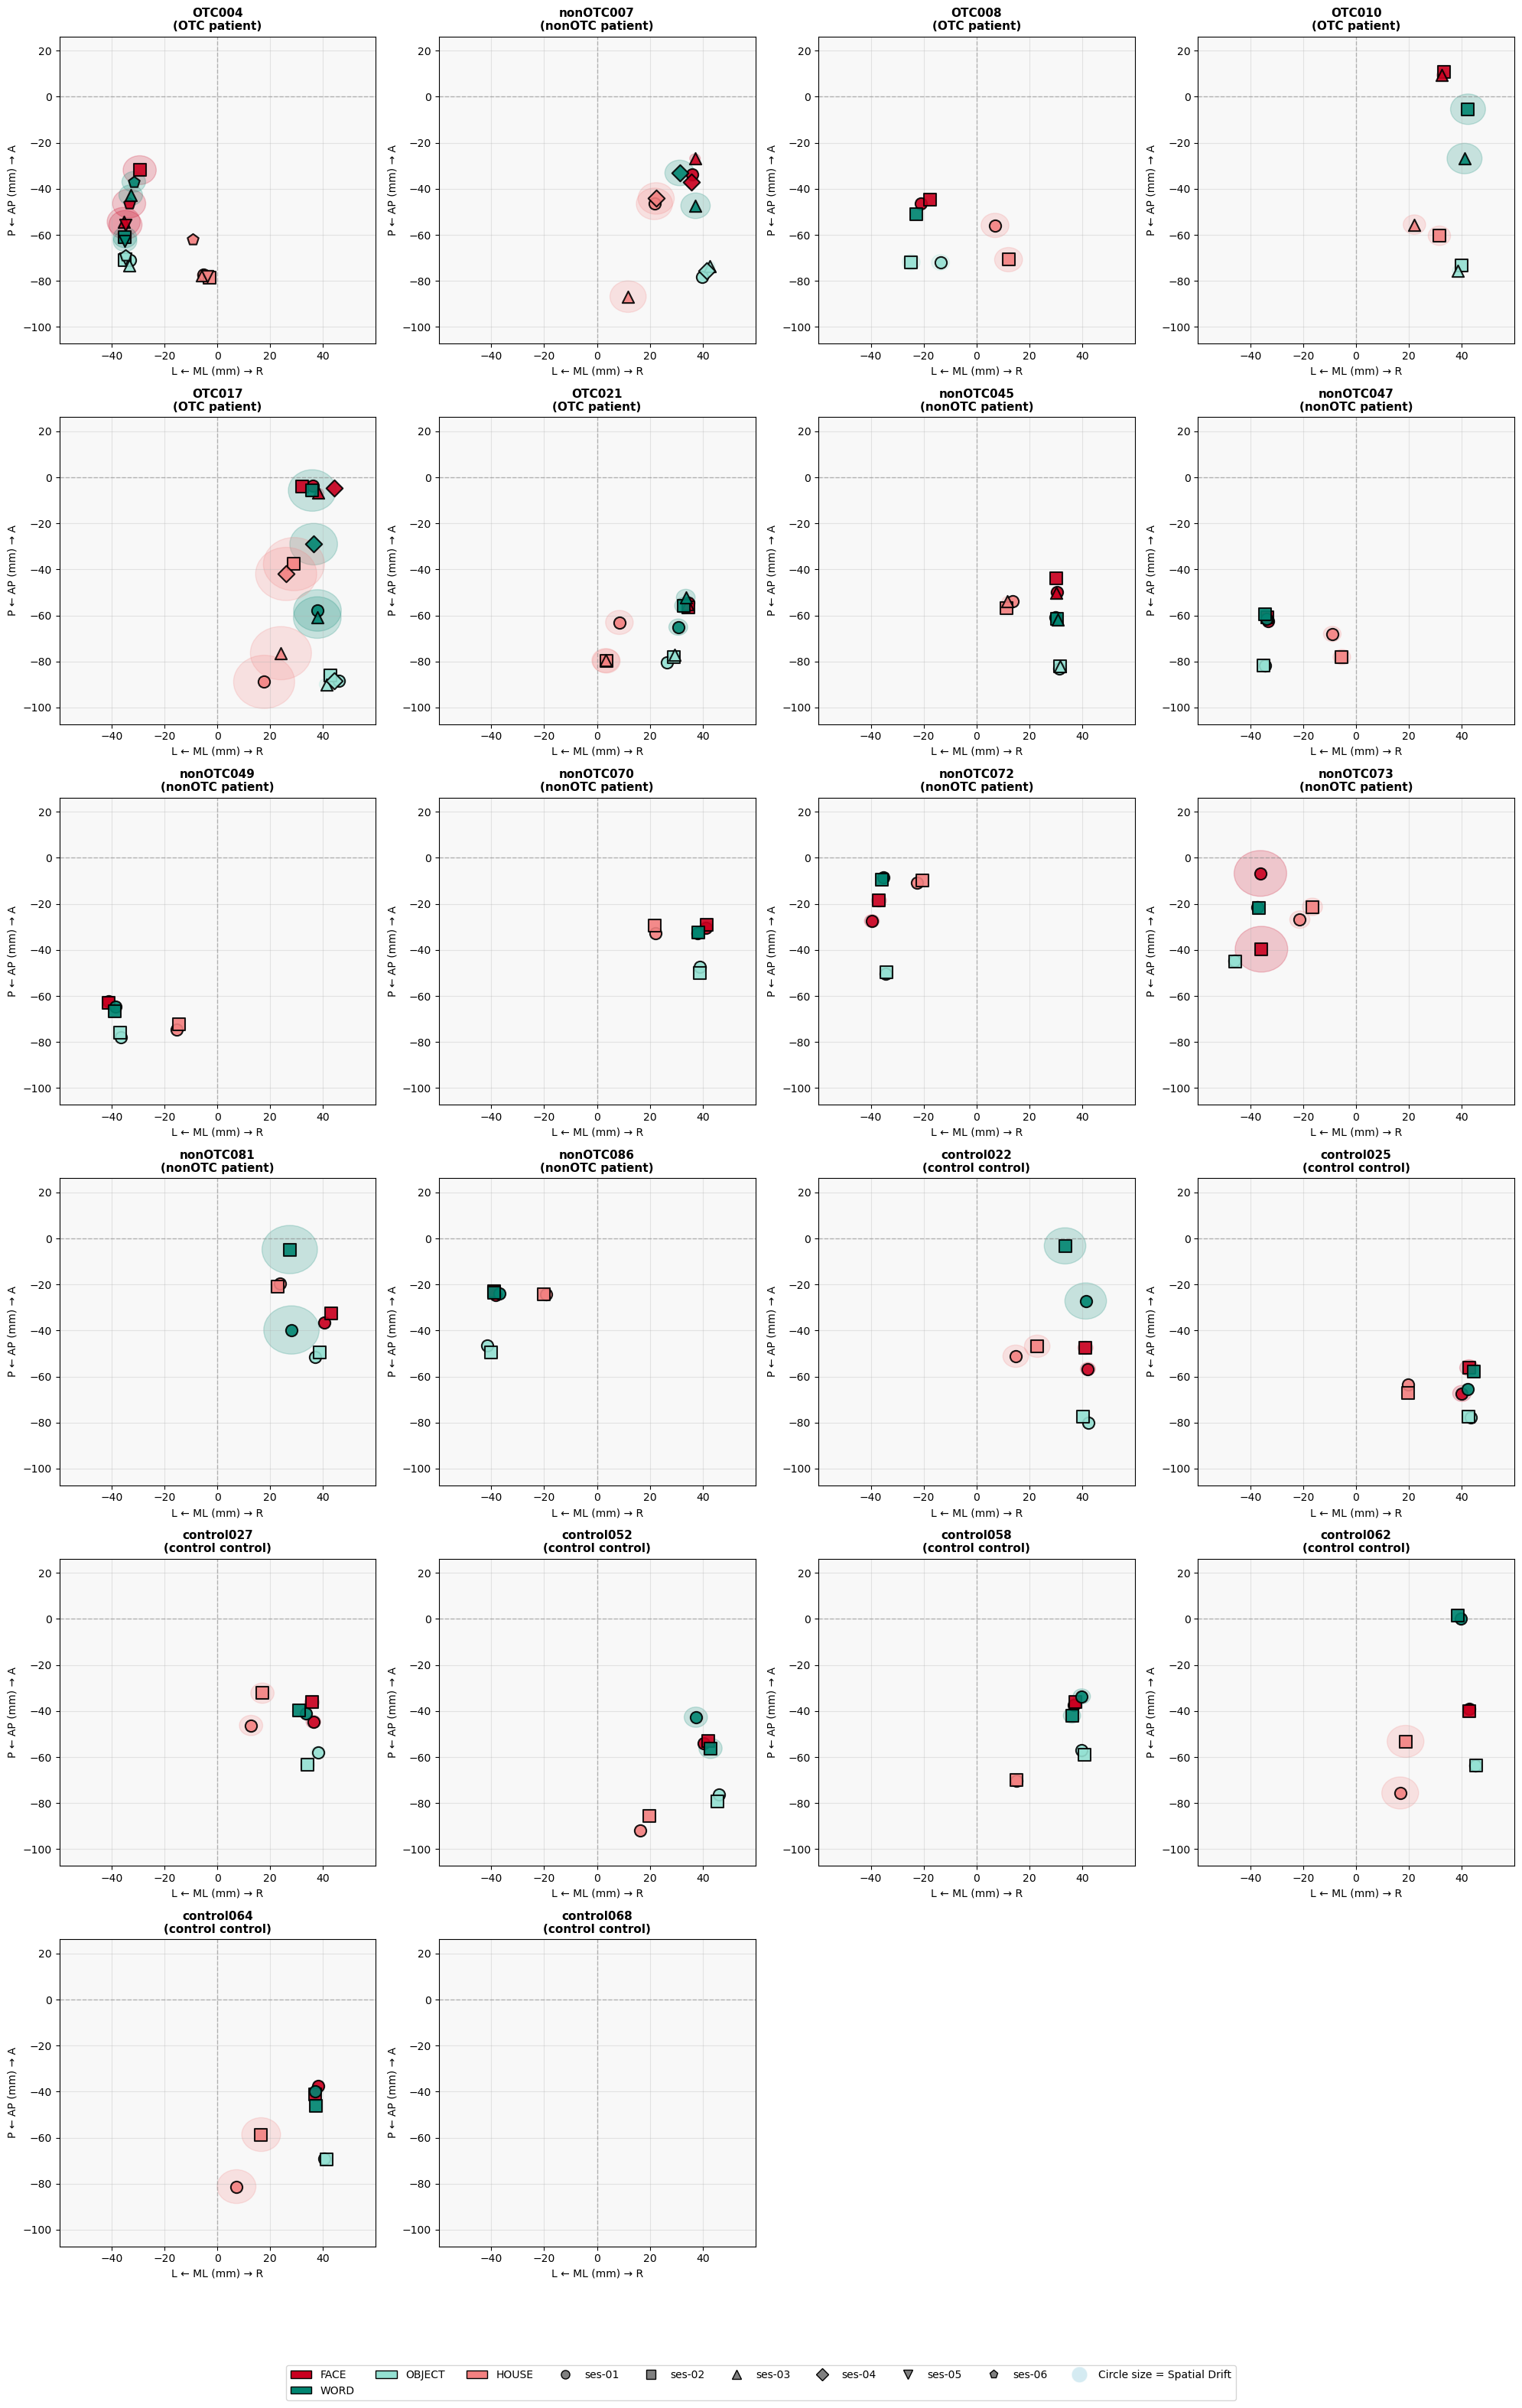

✓ Plotted 22 subjects with drift-scaled circles
Circle size indicates spatial drift magnitude


In [64]:
from matplotlib.patches import Circle

# CELL: Scaled-Up Topography Plot with All Subjects
def plot_comprehensive_topography_with_drift(functional_results, analysis_subjects, results_table):
    """Scaled-up version of your topography plot for all subjects"""
    
    # Filter out subjects with insufficient data
    subjects_to_skip = ['OTC079', 'OTC108', 'control018']
    valid_subjects = [s for s in analysis_subjects.keys() if analysis_subjects[s]['code'] not in subjects_to_skip]
    
    # Create subplot grid (adjust based on number of subjects)
    n_subjects = len(valid_subjects)
    cols = 4  # 4 subjects per row
    rows = (n_subjects + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
    if rows == 1:
        axes = [axes] if n_subjects == 1 else axes
    else:
        axes = axes.flatten()
    
    colors = {'face': '#CA0020', 'word': '#018571', 'object': '#95E1D3', 'house': '#F38181'}
    markers = {'01': 'o', '02': 's', '03': '^', '04': 'D', '05': 'v', '06': 'p'}
    
    # Calculate drift magnitudes for circle sizing
    drift_data = {}
    for subject_id in valid_subjects:
        subject_table = results_table[
            (results_table['Subject'] == analysis_subjects[subject_id]['code']) & 
            (results_table['Category_Type'] != 'Summary')
        ]
        drift_data[subject_id] = {}
        for _, row in subject_table.iterrows():
            category = row['Category'].lower()
            drift_data[subject_id][category] = row['Spatial_Drift_mm']
    
    all_x, all_y = [], []
    
    for idx, subject_id in enumerate(valid_subjects):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        info = analysis_subjects[subject_id]
        code = info['code']
        group_status = f"{info['group']} {info['patient_status']}"
        sessions = info['sessions']
        
        for category in ['face', 'word', 'object', 'house']:
            if category not in functional_results.get(subject_id, {}):
                continue
                
            # Get drift magnitude for this category (for circle sizing)
            drift_magnitude = drift_data[subject_id].get(category, 0)
            circle_radius = max(2.0, drift_magnitude * 0.3)  # Scale drift to reasonable circle size
            
            for session in sessions:
                if session not in functional_results[subject_id][category]:
                    continue
                
                centroid = functional_results[subject_id][category][session]['centroid']
                x, y = centroid[0], centroid[1]
                
                all_x.append(x)
                all_y.append(y)
                
                # Add drift circle (bigger circle = more drift)
                ax.add_patch(Circle((x, y), circle_radius, 
                                  color=colors[category], alpha=0.2, zorder=1))
                
                # Add session point
                ax.scatter(x, y, c=colors[category], marker=markers.get(session, 'o'),
                          s=120, edgecolors='black', linewidth=1.5, alpha=0.9, zorder=3)
        
        # Formatting
        ax.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        ax.set_xlabel('L ← ML (mm) → R', fontsize=10)
        ax.set_ylabel('P ← AP (mm) → A', fontsize=10)
        ax.set_title(f'{code}\n({group_status})', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_facecolor('#F8F8F8')
    
    # Remove empty subplots
    for idx in range(n_subjects, len(axes)):
        fig.delaxes(axes[idx])
    
    # Set consistent axis limits
    if all_x and all_y:
        x_margin = (max(all_x) - min(all_x)) * 0.15
        y_margin = (max(all_y) - min(all_y)) * 0.15
        
        xlim = [min(all_x) - x_margin, max(all_x) + x_margin]
        ylim = [min(all_y) - y_margin, max(all_y) + y_margin]
        
        for idx in range(n_subjects):
            axes[idx].set_xlim(xlim)
            axes[idx].set_ylim(ylim)
    
    # Create legend
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    
    category_legend = [Patch(facecolor=colors[cat], edgecolor='black', label=cat.upper()) 
                      for cat in ['face', 'word', 'object', 'house']]
    session_legend = [Line2D([0], [0], marker=markers.get(s, 'o'), color='w', 
                            markerfacecolor='gray', markersize=8, 
                            markeredgecolor='black', markeredgewidth=1, label=f'ses-{s}')
                     for s in ['01', '02', '03', '04', '05', '06']]
    drift_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue',
                          markersize=15, alpha=0.5, label='Circle size = Spatial Drift')]
    
    fig.legend(handles=category_legend + session_legend + drift_legend, 
              loc='lower center', bbox_to_anchor=(0.5, -0.05), 
              ncol=10, fontsize=10, frameon=True)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'comprehensive_topography_with_drift.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print(f"✓ Plotted {n_subjects} subjects with drift-scaled circles")
    print("Circle size indicates spatial drift magnitude")

# CALL the comprehensive plot
plot_comprehensive_topography_with_drift(golarai_functional_final, ANALYSIS_SUBJECTS, results_table_complete)

In [67]:
# Three-Group Analysis: OTC vs nonOTC vs Controls
def three_group_analysis(results_table, analysis_subjects):
    """Proper analysis: OTC (interest) vs nonOTC (patient control) vs Controls (healthy)"""
    
    # Clean data and add age information
    clean_data = results_table[
        (results_table['Category_Type'] != 'Summary') &
        (~results_table['Subject'].isin(['OTC079', 'OTC108', 'control018']))
    ].copy()
    
    # Add age information
    clean_data['age_1'] = clean_data['Subject'].map(
        {info['code']: info['age_1'] for subject_id, info in analysis_subjects.items()}
    )
    
    print("THREE-GROUP COMPARISON: OTC vs nonOTC vs Controls")
    print("="*70)
    
    # Define the three groups
    otc_patients = clean_data[clean_data['Group'] == 'OTC']
    nonotc_patients = clean_data[clean_data['Group'] == 'nonOTC']  
    healthy_controls = clean_data[clean_data['Group'] == 'control']
    
    # Group demographics
    print("GROUP DEMOGRAPHICS:")
    for group_name, group_data in [('OTC', otc_patients), ('nonOTC', nonotc_patients), ('Controls', healthy_controls)]:
        subject_ages = group_data.groupby('Subject')['age_1'].first().dropna()
        n_subjects = len(group_data['Subject'].unique())
        if len(subject_ages) > 0:
            print(f"{group_name}: n={n_subjects}, age={subject_ages.mean():.1f}±{subject_ages.std():.1f} years")
    
    # Main comparisons by category type
    print(f"\nSPATIAL DRIFT COMPARISON:")
    print(f"{'Group':<12} {'Bilateral':<12} {'Unilateral':<12} {'Difference':<12}")
    print("-" * 50)
    
    group_results = {}
    
    for group_name, group_data in [('OTC', otc_patients), ('nonOTC', nonotc_patients), ('Controls', healthy_controls)]:
        bilateral = group_data[group_data['Category_Type'] == 'Bilateral']['Spatial_Drift_mm']
        unilateral = group_data[group_data['Category_Type'] == 'Unilateral']['Spatial_Drift_mm']
        
        bil_mean = bilateral.mean() if len(bilateral) > 0 else 0
        uni_mean = unilateral.mean() if len(unilateral) > 0 else 0
        difference = uni_mean - bil_mean
        
        print(f"{group_name:<12} {bil_mean:<12.1f} {uni_mean:<12.1f} {difference:<12.1f}")
        
        group_results[group_name] = {
            'bilateral_spatial': bil_mean,
            'unilateral_spatial': uni_mean,
            'spatial_difference': difference
        }
    
    print(f"\nREPRESENTATIONAL CHANGE COMPARISON:")
    print(f"{'Group':<12} {'Bilateral':<12} {'Unilateral':<12} {'Difference':<12}")
    print("-" * 50)
    
    for group_name, group_data in [('OTC', otc_patients), ('nonOTC', nonotc_patients), ('Controls', healthy_controls)]:
        bilateral = group_data[group_data['Category_Type'] == 'Bilateral']['Representational_Change']
        unilateral = group_data[group_data['Category_Type'] == 'Unilateral']['Representational_Change']
        
        bil_mean = bilateral.mean() if len(bilateral) > 0 else 0
        uni_mean = unilateral.mean() if len(unilateral) > 0 else 0
        difference = bil_mean - uni_mean  # For repr, bilateral > unilateral is expected
        
        print(f"{group_name:<12} {bil_mean:<12.3f} {uni_mean:<12.3f} {difference:<12.3f}")
        
        group_results[group_name]['bilateral_repr'] = bil_mean
        group_results[group_name]['unilateral_repr'] = uni_mean
        group_results[group_name]['repr_difference'] = difference
    
    # Coupling analysis
    print(f"\nSPATIAL-REPRESENTATIONAL COUPLING:")
    print(f"{'Group':<12} {'Bilateral r':<12} {'Unilateral r':<12}")
    print("-" * 40)
    
    for group_name, group_data in [('OTC', otc_patients), ('nonOTC', nonotc_patients), ('Controls', healthy_controls)]:
        # Bilateral coupling
        bilateral_data = group_data[group_data['Category_Type'] == 'Bilateral']
        if len(bilateral_data) > 3:
            bil_coupling = np.corrcoef(bilateral_data['Spatial_Drift_mm'], bilateral_data['Representational_Change'])[0,1]
        else:
            bil_coupling = np.nan
        
        # Unilateral coupling  
        unilateral_data = group_data[group_data['Category_Type'] == 'Unilateral']
        if len(unilateral_data) > 3:
            uni_coupling = np.corrcoef(unilateral_data['Spatial_Drift_mm'], unilateral_data['Representational_Change'])[0,1]
        else:
            uni_coupling = np.nan
        
        print(f"{group_name:<12} {bil_coupling:<12.3f} {uni_coupling:<12.3f}")
    
    # Statistical tests
    from scipy.stats import ttest_ind
    
    print(f"\nSTATISTICAL TESTS (OTC vs Controls):")
    
    # Test bilateral categories
    otc_bilateral = otc_patients[otc_patients['Category_Type'] == 'Bilateral']
    ctrl_bilateral = healthy_controls[healthy_controls['Category_Type'] == 'Bilateral']
    
    if len(otc_bilateral) > 0 and len(ctrl_bilateral) > 0:
        spatial_stat, spatial_p = ttest_ind(otc_bilateral['Spatial_Drift_mm'], ctrl_bilateral['Spatial_Drift_mm'])
        repr_stat, repr_p = ttest_ind(otc_bilateral['Representational_Change'], ctrl_bilateral['Representational_Change'])
        
        print(f"Bilateral categories:")
        print(f"  Spatial drift: t={spatial_stat:.3f}, p={spatial_p:.3f}")
        print(f"  Repr change: t={repr_stat:.3f}, p={repr_p:.3f}")
    
    # Test unilateral categories
    otc_unilateral = otc_patients[otc_patients['Category_Type'] == 'Unilateral']
    ctrl_unilateral = healthy_controls[healthy_controls['Category_Type'] == 'Unilateral']
    
    if len(otc_unilateral) > 0 and len(ctrl_unilateral) > 0:
        spatial_stat, spatial_p = ttest_ind(otc_unilateral['Spatial_Drift_mm'], ctrl_unilateral['Spatial_Drift_mm'])
        repr_stat, repr_p = ttest_ind(otc_unilateral['Representational_Change'], ctrl_unilateral['Representational_Change'])
        
        print(f"Unilateral categories:")
        print(f"  Spatial drift: t={spatial_stat:.3f}, p={spatial_p:.3f}")
        print(f"  Repr change: t={repr_stat:.3f}, p={repr_p:.3f}")
    
    print(f"\nKEY FINDINGS:")
    print(f"1. Neural crowding hypothesis: Do bilateral categories show more plasticity?")
    for group_name in ['OTC', 'nonOTC', 'Controls']:
        if group_results[group_name]['repr_difference'] > 0:
            print(f"   {group_name}: ✓ Bilateral > Unilateral ({group_results[group_name]['repr_difference']:.3f})")
        else:
            print(f"   {group_name}: ✗ Unilateral ≥ Bilateral ({group_results[group_name]['repr_difference']:.3f})")
    
    print(f"\n2. Patient-control differences:")
    otc_bil = group_results['OTC']['bilateral_spatial']
    ctrl_bil = group_results['Controls']['bilateral_spatial']
    print(f"   OTC vs Controls bilateral spatial drift: {otc_bil:.1f} vs {ctrl_bil:.1f}mm (diff: {otc_bil-ctrl_bil:.1f}mm)")
    
    return group_results

# RUN the three-group analysis
three_group_results = three_group_analysis(results_table_complete, ANALYSIS_SUBJECTS)

THREE-GROUP COMPARISON: OTC vs nonOTC vs Controls
GROUP DEMOGRAPHICS:
OTC: n=5, age=12.9±3.1 years
nonOTC: n=9, age=14.8±2.2 years
Controls: n=7, age=11.4±2.6 years

SPATIAL DRIFT COMPARISON:
Group        Bilateral    Unilateral   Difference  
--------------------------------------------------
OTC          12.4         11.5         -0.9        
nonOTC       4.5          7.1          2.6         
Controls     8.4          8.0          -0.4        

REPRESENTATIONAL CHANGE COMPARISON:
Group        Bilateral    Unilateral   Difference  
--------------------------------------------------
OTC          0.368        0.143        0.226       
nonOTC       0.140        0.131        0.008       
Controls     0.243        0.108        0.134       

SPATIAL-REPRESENTATIONAL COUPLING:
Group        Bilateral r  Unilateral r
----------------------------------------
OTC          0.165        0.104       
nonOTC       -0.138       0.344       
Controls     0.368        -0.386      

STATISTICAL TESTS (

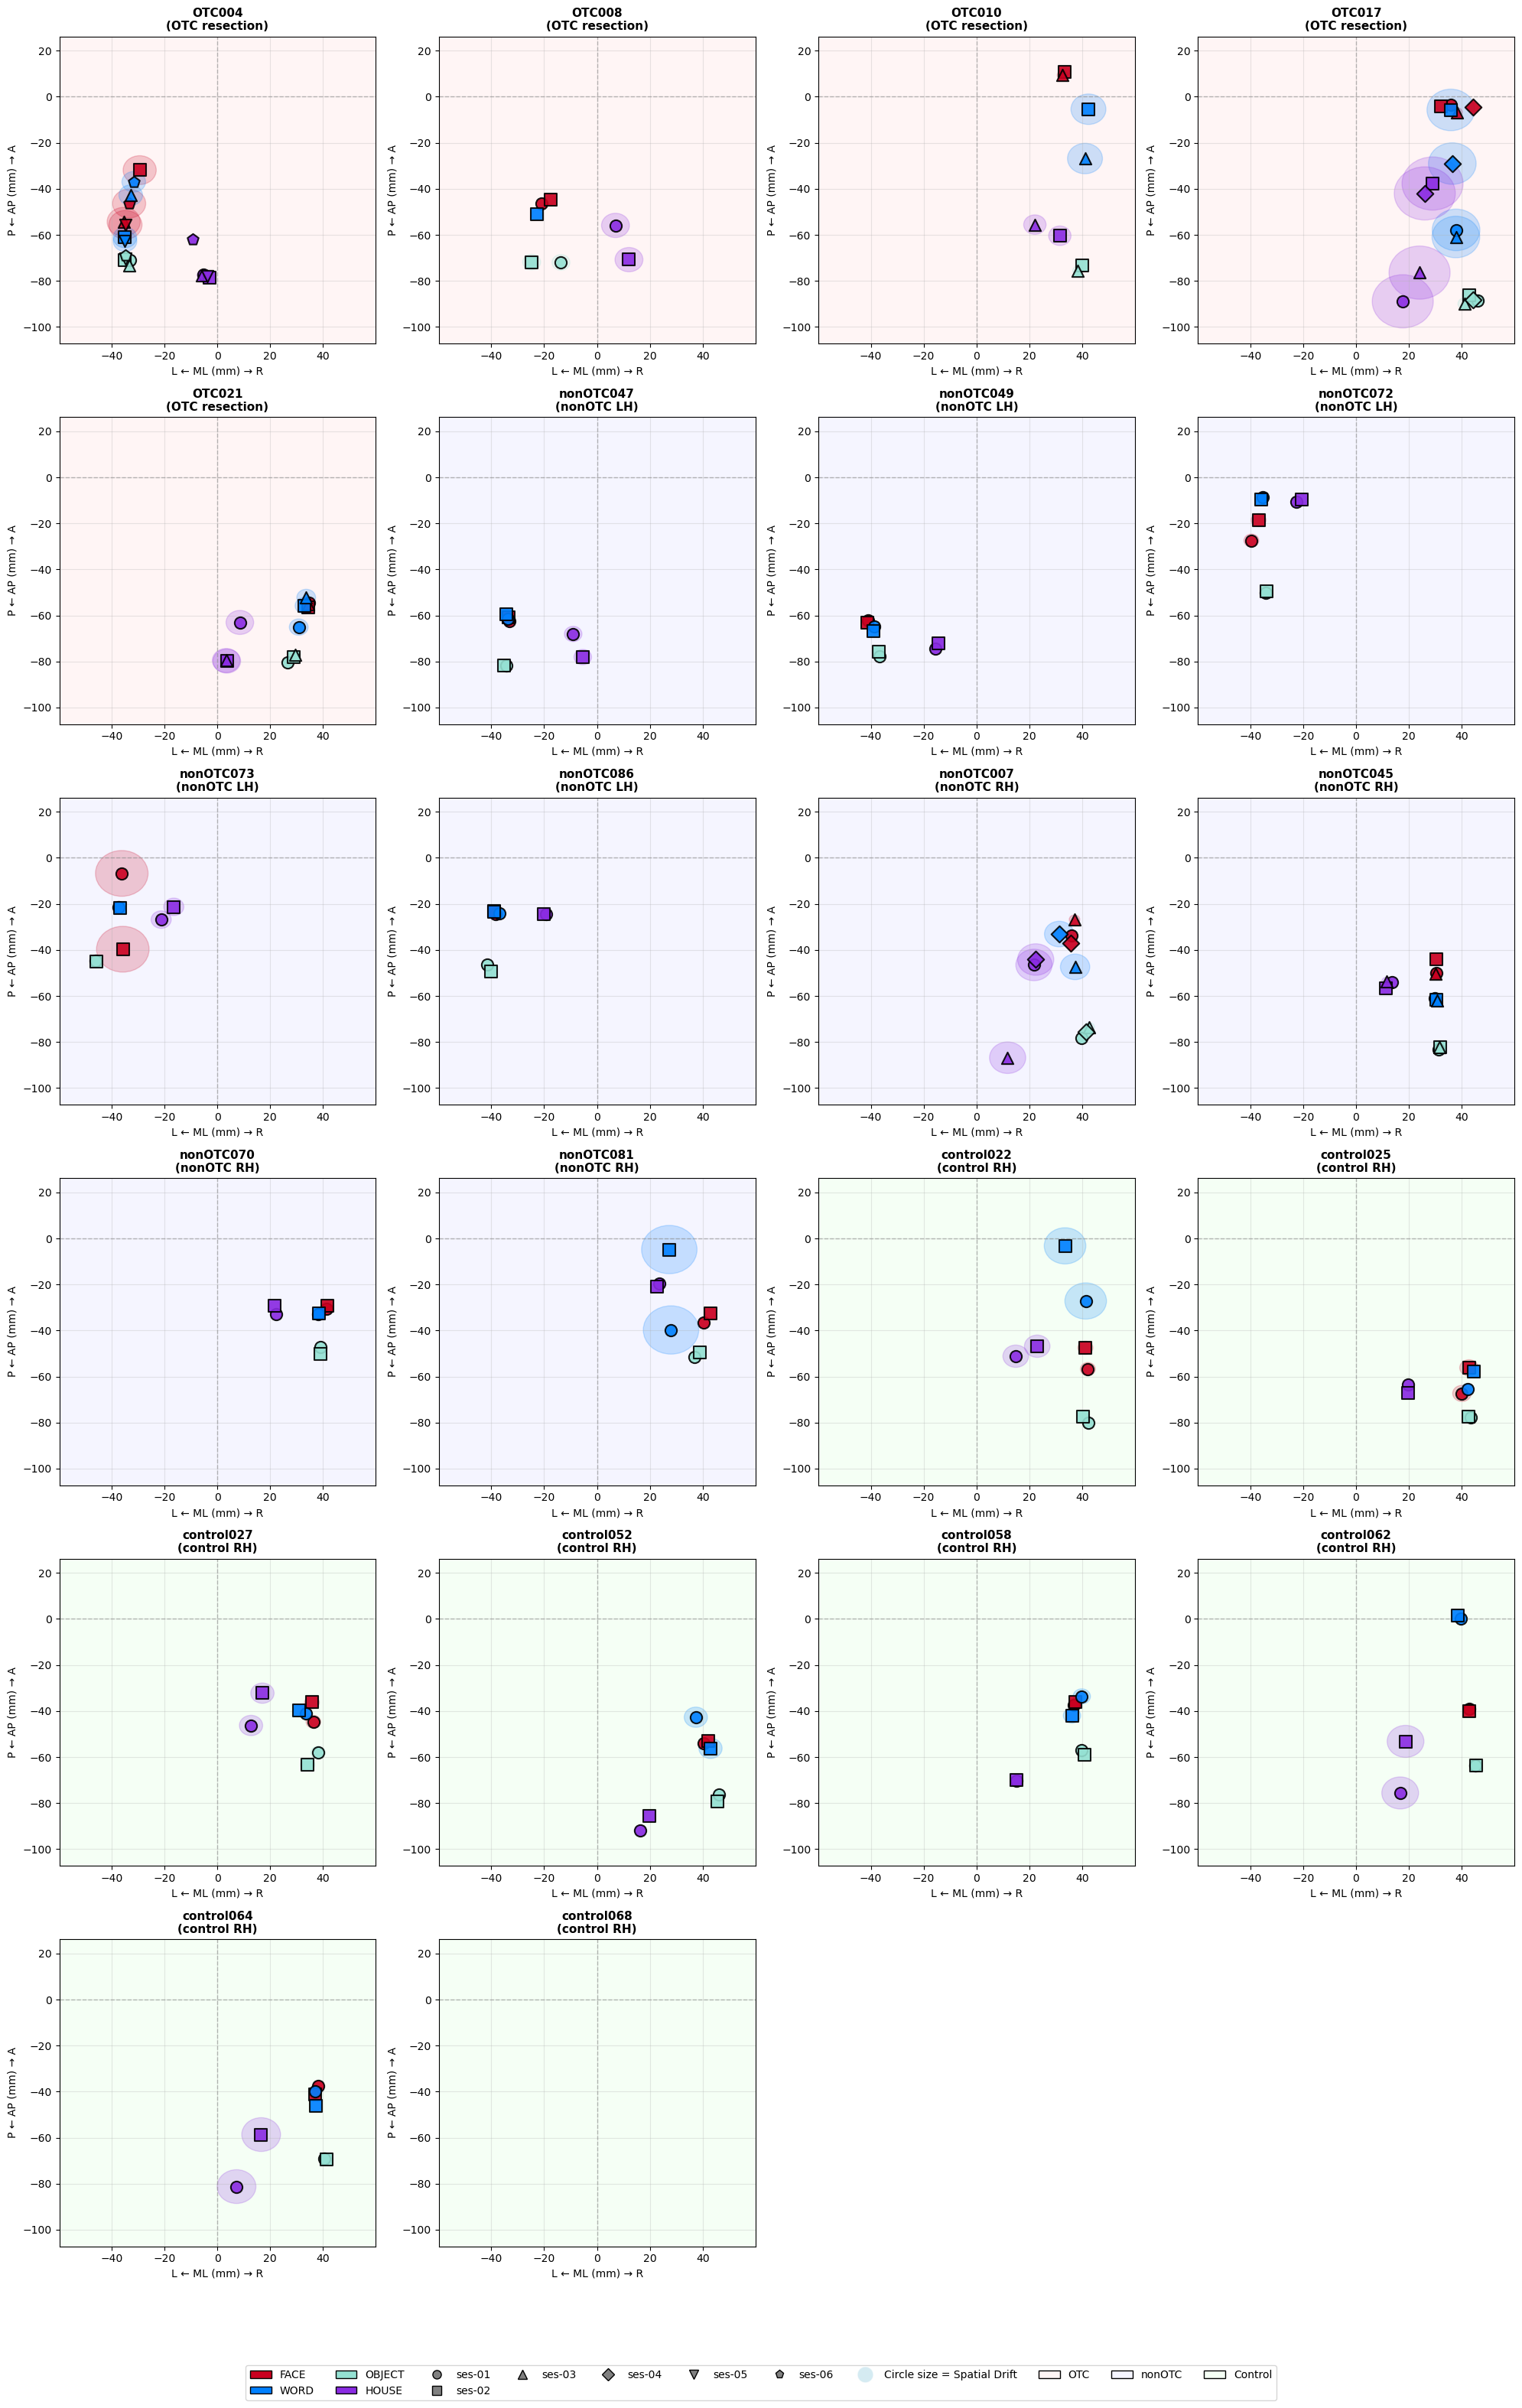

✓ Plotted 22 subjects with hemisphere awareness
OTC: 5, nonOTC: 9, Controls: 8
Circle size indicates spatial drift magnitude
Background colors: Red=OTC, Blue=nonOTC, Green=Control


In [68]:
from matplotlib.patches import Circle

# CELL: Updated Topography Plot - Hemisphere-Aware for Controls + New Colors
def plot_comprehensive_topography_with_drift_updated(functional_results, analysis_subjects, results_table):
    """Updated version with hemisphere-aware controls and new color scheme"""
    
    # Filter out subjects with insufficient data
    subjects_to_skip = ['OTC079', 'OTC108', 'control018']
    valid_subjects = [s for s in analysis_subjects.keys() if analysis_subjects[s]['code'] not in subjects_to_skip]
    
    # NEW COLOR SCHEME: purple house, bright blue word
    colors = {
        'face': '#CA0020',      # Keep red 
        'word': '#0080FF',      # Bright blue (was dark green)
        'object': '#95E1D3',    # Keep light mint
        'house': '#8A2BE2'      # Purple (was light pink)
    }
    markers = {'01': 'o', '02': 's', '03': '^', '04': 'D', '05': 'v', '06': 'p'}
    
    # Organize subjects by group for better layout
    otc_subjects = [s for s in valid_subjects if analysis_subjects[s]['group'] == 'OTC']
    nonotc_subjects = [s for s in valid_subjects if analysis_subjects[s]['group'] == 'nonOTC'] 
    control_subjects = [s for s in valid_subjects if analysis_subjects[s]['group'] == 'control']
    
    # For controls and nonOTC, we want to show hemisphere information
    # Separate by hemisphere if available
    nonotc_left = [s for s in nonotc_subjects if analysis_subjects[s]['hemi'] == 'l']
    nonotc_right = [s for s in nonotc_subjects if analysis_subjects[s]['hemi'] == 'r']
    control_left = [s for s in control_subjects if analysis_subjects[s]['hemi'] == 'l'] 
    control_right = [s for s in control_subjects if analysis_subjects[s]['hemi'] == 'r']
    
    # Organize plot order: OTC, then nonOTC (L then R), then Controls (L then R)
    plot_order = (otc_subjects + 
                 nonotc_left + nonotc_right + 
                 control_left + control_right)
    
    n_subjects = len(plot_order)
    cols = 4  # 4 subjects per row
    rows = (n_subjects + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
    if rows == 1:
        axes = [axes] if n_subjects == 1 else axes
    else:
        axes = axes.flatten()
    
    # Calculate drift magnitudes for circle sizing
    drift_data = {}
    for subject_id in valid_subjects:
        subject_table = results_table[
            (results_table['Subject'] == analysis_subjects[subject_id]['code']) & 
            (results_table['Category_Type'] != 'Summary')
        ]
        drift_data[subject_id] = {}
        for _, row in subject_table.iterrows():
            category = row['Category'].lower()
            drift_data[subject_id][category] = row['Spatial_Drift_mm']
    
    all_x, all_y = [], []
    
    for idx, subject_id in enumerate(plot_order):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        info = analysis_subjects[subject_id]
        code = info['code']
        group = info['group']
        hemisphere = info['hemi']
        
        # Enhanced title showing hemisphere for controls/nonOTC
        if group in ['nonOTC', 'control']:
            title = f"{code}\n({group} {hemisphere.upper()}H)"
        else:
            title = f"{code}\n({group} resection)"
        
        sessions = info['sessions']
        
        for category in ['face', 'word', 'object', 'house']:
            if category not in functional_results.get(subject_id, {}):
                continue
                
            # Get drift magnitude for this category (for circle sizing)
            drift_magnitude = drift_data[subject_id].get(category, 0)
            circle_radius = max(2.0, drift_magnitude * 0.3)  # Scale drift to reasonable circle size
            
            for session in sessions:
                if session not in functional_results[subject_id][category]:
                    continue
                
                centroid = functional_results[subject_id][category][session]['centroid']
                x, y = centroid[0], centroid[1]
                
                all_x.append(x)
                all_y.append(y)
                
                # Add drift circle (bigger circle = more drift)
                ax.add_patch(Circle((x, y), circle_radius, 
                                  color=colors[category], alpha=0.2, zorder=1))
                
                # Add session point
                ax.scatter(x, y, c=colors[category], marker=markers.get(session, 'o'),
                          s=120, edgecolors='black', linewidth=1.5, alpha=0.9, zorder=3)
        
        # Formatting
        ax.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        ax.set_xlabel('L ← ML (mm) → R', fontsize=10)
        ax.set_ylabel('P ← AP (mm) → A', fontsize=10)
        ax.set_title(title, fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Color-code background by group
        if group == 'OTC':
            ax.set_facecolor('#FFF5F5')  # Light red tint
        elif group == 'nonOTC':
            ax.set_facecolor('#F5F5FF')  # Light blue tint  
        else:  # control
            ax.set_facecolor('#F5FFF5')  # Light green tint
    
    # Remove empty subplots
    for idx in range(n_subjects, len(axes)):
        fig.delaxes(axes[idx])
    
    # Set consistent axis limits
    if all_x and all_y:
        x_margin = (max(all_x) - min(all_x)) * 0.15
        y_margin = (max(all_y) - min(all_y)) * 0.15
        
        xlim = [min(all_x) - x_margin, max(all_x) + x_margin]
        ylim = [min(all_y) - y_margin, max(all_y) + y_margin]
        
        for idx in range(n_subjects):
            axes[idx].set_xlim(xlim)
            axes[idx].set_ylim(ylim)
    
    # Create legend with updated colors
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    
    category_legend = [Patch(facecolor=colors[cat], edgecolor='black', label=cat.upper()) 
                      for cat in ['face', 'word', 'object', 'house']]
    session_legend = [Line2D([0], [0], marker=markers.get(s, 'o'), color='w', 
                            markerfacecolor='gray', markersize=8, 
                            markeredgecolor='black', markeredgewidth=1, label=f'ses-{s}')
                     for s in ['01', '02', '03', '04', '05', '06']]
    drift_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue',
                          markersize=15, alpha=0.5, label='Circle size = Spatial Drift')]
    group_legend = [
        Patch(facecolor='#FFF5F5', edgecolor='black', label='OTC'),
        Patch(facecolor='#F5F5FF', edgecolor='black', label='nonOTC'), 
        Patch(facecolor='#F5FFF5', edgecolor='black', label='Control')
    ]
    
    fig.legend(handles=category_legend + session_legend + drift_legend + group_legend, 
              loc='lower center', bbox_to_anchor=(0.5, -0.05), 
              ncol=11, fontsize=10, frameon=True)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'comprehensive_topography_hemisphere_aware.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print(f"✓ Plotted {n_subjects} subjects with hemisphere awareness")
    print(f"OTC: {len(otc_subjects)}, nonOTC: {len(nonotc_subjects)}, Controls: {len(control_subjects)}")
    print("Circle size indicates spatial drift magnitude")
    print("Background colors: Red=OTC, Blue=nonOTC, Green=Control")

# CALL the updated comprehensive plot
plot_comprehensive_topography_with_drift_updated(golarai_functional_final, ANALYSIS_SUBJECTS, results_table_complete)